# Assignment 05
## Case : MRI and Alzheimers
source : https://www.kaggle.com/jboysen/mri-and-alzheimers

## Import Library

In [0]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
import tensorflow as tf

from tqdm import tqdm

from tensorflow.python.keras.utils import np_utils
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve,classification_report

## Framework
#### CRISP-DM (Cross-Industry Standard Process for Data Mining)
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b9/CRISP-DM_Process_Diagram.png/220px-CRISP-DM_Process_Diagram.png">

In this case, we use framework CRISP-DM that divided into 6 steps :

1.   Business Understanding
2.   Data Understanding
3.   Data Preparation
4.   Modeling
5    Evaluation
6.   Deployment



# Business Understanding

### Problem Statements:
The Open Access Series of Imaging Studies (OASIS) is a project aimed at making MRI data sets of the brain freely available to the scientific community. By compiling and freely distributing MRI data sets, we hope to facilitate future discoveries in basic and clinical neuroscience. OASIS is made available by the Washington University Alzheimer’s Disease Research Center, Dr. Randy Buckner at the Howard Hughes Medical Institute (HHMI)( at Harvard University, the Neuroinformatics Research Group (NRG) at Washington University School of Medicine, and the Biomedical Informatics Research Network (BIRN).

### Objective :
Build Machine Learning Model to predict Dementia based on available dataset.

# Data Understanding

Longitudinal MRI Data in Nondemented and Demented Older Adults: This set consists of a longitudinal collection of 150 subjects aged 60 to 96. Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 72 of the subjects were characterized as nondemented throughout the study. 64 of the included subjects were characterized as demented at the time of their initial visits and remained so for subsequent scans, including 51 individuals with mild to moderate Alzheimer’s disease. Another 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit.

## Import Dataset

In [0]:
# from google.colab import drive
# drive.mount("/content/drive")

In [4]:
# df = pd.read_csv('/content/drive/My Drive/Bangkit/Bangkit_Assignment05/Dataset/oasis_longitudinal.csv')
df = pd.read_csv('https://raw.githubusercontent.com/leofire19/bangkit_assignment05/master/Dataset/oasis_longitudinal.csv')
df['Group'] = df['Group'].replace(['Converted'], ['Demented'])
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


### Data Dictionary
- Subject ID : ID of Subject Observation  
- MRI ID : ID of MRI Subject Observation  
- Visit : Count of Subject ID Visit  
- MR Delay : Delay  
- M/F : Gender of Subject (Male/Female)  
- Hand : Right Handed/Left Handed 
- Age : Age of Subject   
- EDUC 	: Years of education  
- SES 	: Socioeconomic Status  
- MMSE 	: Mini Mental State Examination  
- CDR 	: Clinical Dementia Rating  
- eTIV 	: Estimated Total Intracranial Volume  
- nWBV 	: Normalize Whole Brain Volume  
- ASF 	: Atlas Scaling Factor

Label or Target Variabel : Group (Demented/Nondemented)

### Overview of Data's Characteristic

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


There is two type of feature in dataset:
1. Categoric = Subject ID, MRI ID, Group, M/F, Hand
2. Numeric = Visit, MR Delay, Age, EDUC, SES, MMSE, CDR, eTIV,
 nWBV, ASF

# Data Preparation


### Inspect Data Type

In [6]:
df.dtypes

Subject ID     object
MRI ID         object
Group          object
Visit           int64
MR Delay        int64
M/F            object
Hand           object
Age             int64
EDUC            int64
SES           float64
MMSE          float64
CDR           float64
eTIV            int64
nWBV          float64
ASF           float64
dtype: object

### Check Duplicated

In [7]:
df.duplicated().any()
df.duplicated(subset=['Subject ID','MRI ID']).any()

False

There is no duplicated found in dataset

### Check Missing Value

In [0]:
## Check Missing Value
def get_missing_value(df):
    '''
     Fungsi get_missing_value
     Input berupa pandas dataframe
     Output/return menghasilkan tabel yang berisi kolom beserta jumlah dan presentase missing value pada dataset 
    '''

    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data.loc[missing_data["Percent"]> 0]
    if missing_data.shape[0]==0:
        print("There is no missing Value!!!")
    else:
        print('There is missing value')
        return missing_data

In [9]:
miss_df = get_missing_value(df)
miss_df

There is missing value


,Total,Percent
SES,19,0.050938
MMSE,2,0.005362


## Handle Missing Value
We use mode imputation to fill missing value in dataset

In [0]:
df['SES'] = df['SES'].fillna(df['SES'].mode()[0])
df['MMSE'] = df['MMSE'].fillna(df['MMSE'].mode()[0])

## Exploratory Data Analysis

## Check Imbalance Data

In [11]:
df['Group'].value_counts()

Nondemented    190
Demented       183
Name: Group, dtype: int64

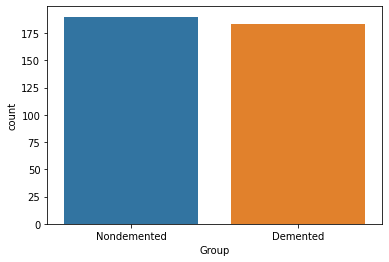

In [12]:
ax = sns.countplot(data = df,x='Group')
plt.show()

The data is balance

#### Numerical Features

In [13]:
df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.436997,27.356568,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.109307,3.678467,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


#### Categorical Features

In [14]:
df.describe(include=['object','category'])

,Subject ID,MRI ID,Group,M/F,Hand
count,373,373,373,373,373
unique,150,373,2,2,1
top,OAS2_0073,OAS2_0061_MR1,Nondemented,F,R
freq,5,1,190,213,373


### Drop Unnecessary Column

In [0]:
df.drop(['Subject ID','MRI ID','Hand'],axis=1,inplace=True)

#### Corellation Plot

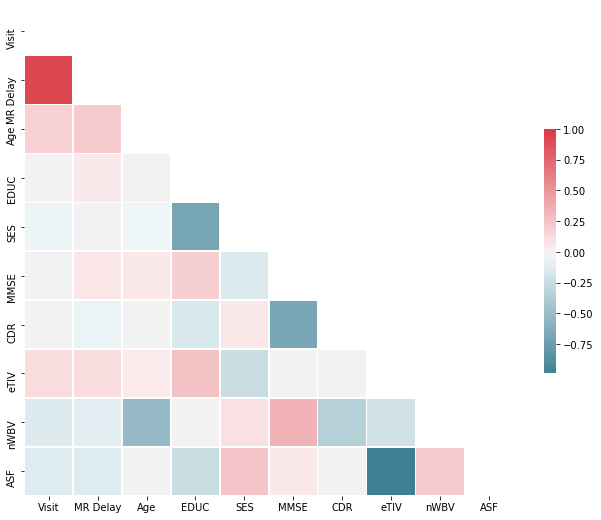

In [16]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [17]:
corr

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
Visit,1.000000,0.920009,0.183213,0.024615,-0.049294,-0.026378,0.002325,0.117428,-0.126682,-0.120399
MR Delay,0.920009,1.000000,0.205357,0.051630,-0.026247,0.067087,-0.062915,0.119624,-0.105586,-0.123545
Age,0.183213,0.205357,1.000000,-0.027886,-0.045410,0.055014,-0.026257,0.042348,-0.518359,-0.035067
EDUC,0.024615,0.051630,-0.027886,1.000000,-0.691222,0.190674,-0.153121,0.257015,-0.012200,-0.241752
SES,-0.049294,-0.026247,-0.045410,-0.691222,1.000000,-0.140399,0.052313,-0.249030,0.092361,0.240831
MMSE,-0.026378,0.067087,0.055014,0.190674,-0.140399,1.000000,-0.671533,-0.038892,0.342209,0.048230
CDR,0.002325,-0.062915,-0.026257,-0.153121,0.052313,-0.671533,1.000000,0.022819,-0.344819,-0.029340
eTIV,0.117428,0.119624,0.042348,0.257015,-0.249030,-0.038892,0.022819,1.000000,-0.210122,-0.988877
nWBV,-0.126682,-0.105586,-0.518359,-0.012200,0.092361,0.342209,-0.344819,-0.210122,1.000000,0.213476
ASF,-0.120399,-0.123545,-0.035067,-0.241752,0.240831,0.048230,-0.029340,-0.988877,0.213476,1.000000


### Drop Feature That Has High Correlation (>0.8)

In [0]:
# Visit with MR Delay has correlation score 0.92
# eTIV with ASF has correlation score -0.98
df.drop(['Visit','eTIV'],axis=1,inplace=True)

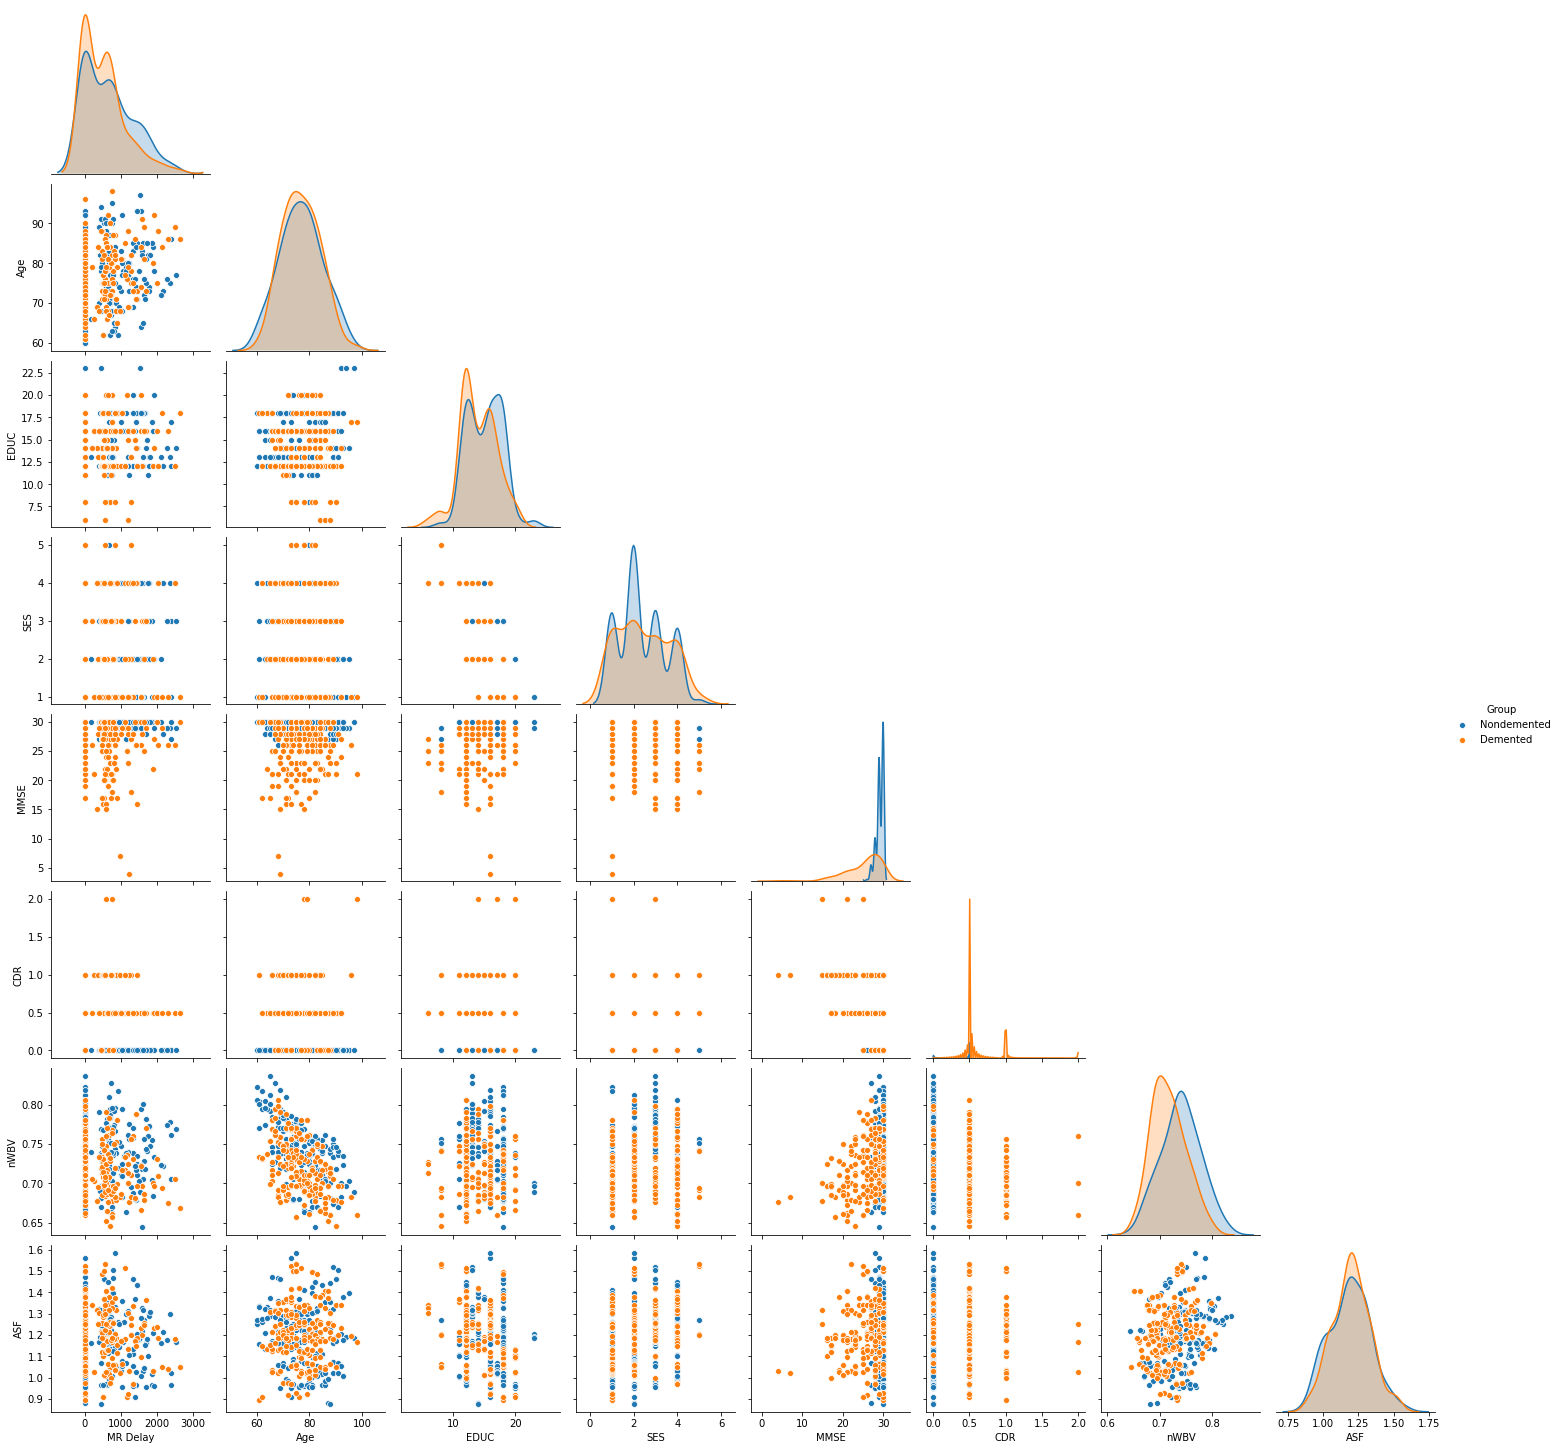

In [19]:
sns_train = sns.pairplot(df,hue='Group',corner = True)

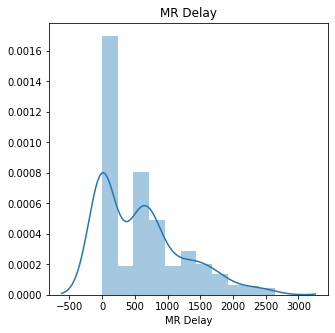

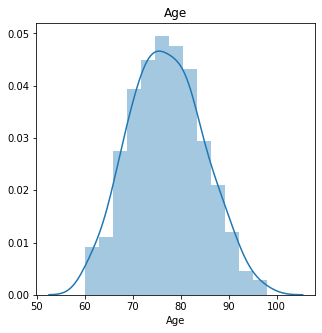

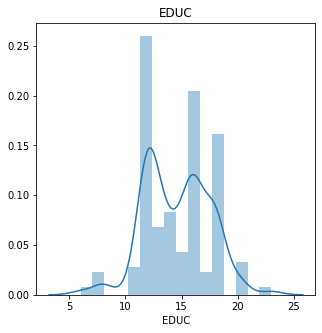

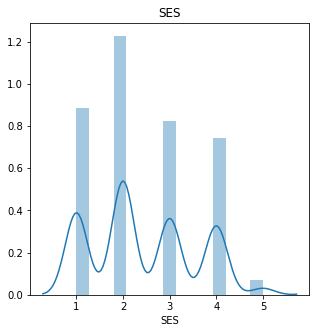

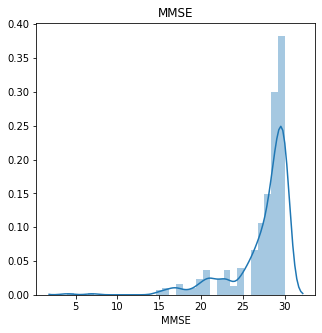

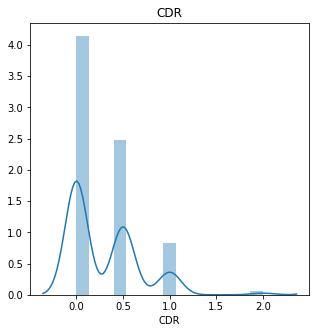

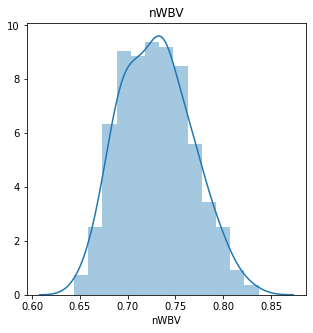

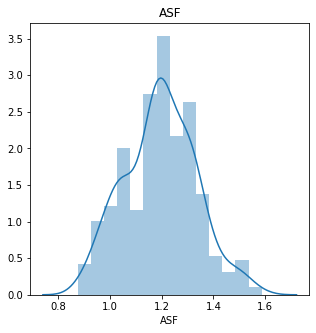

In [20]:
for i in list(df.select_dtypes('number')):
    plt.figure(figsize=(5,5))
    sns.distplot(df[i]).set_title(i)

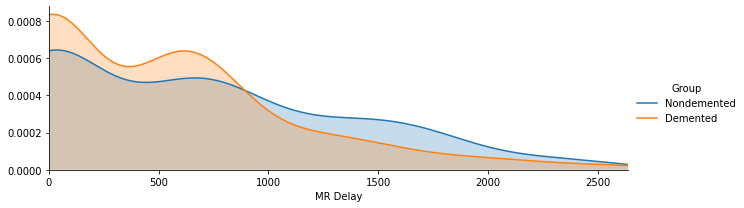

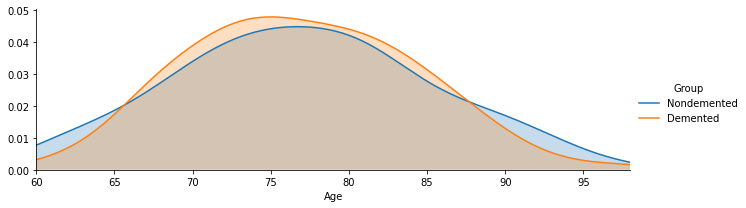

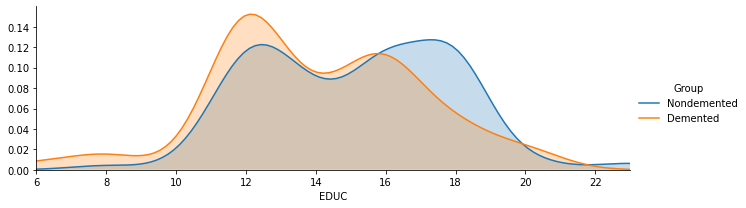

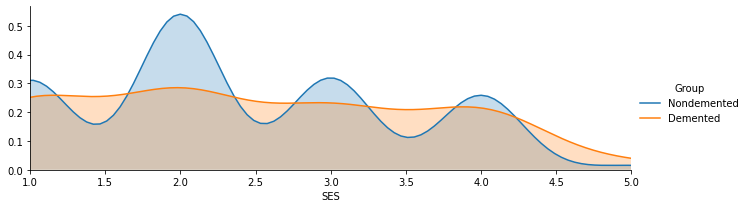

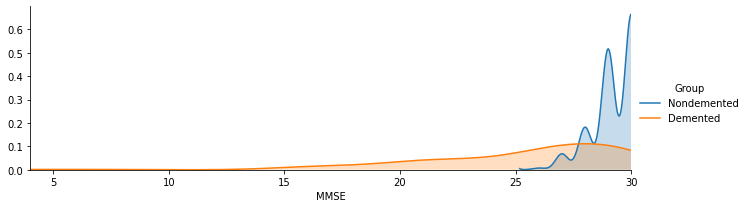

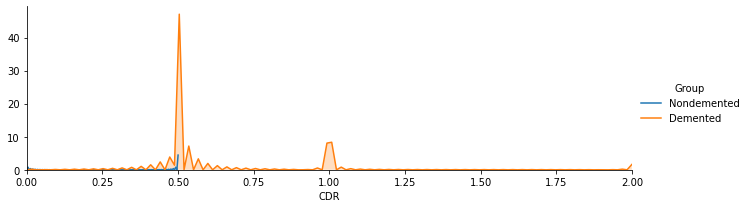

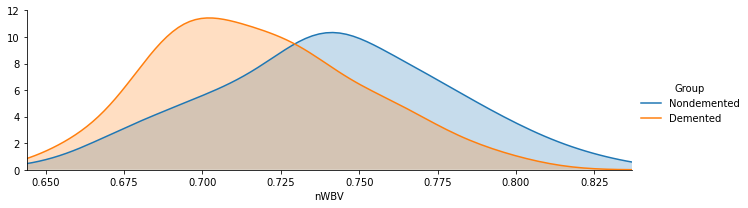

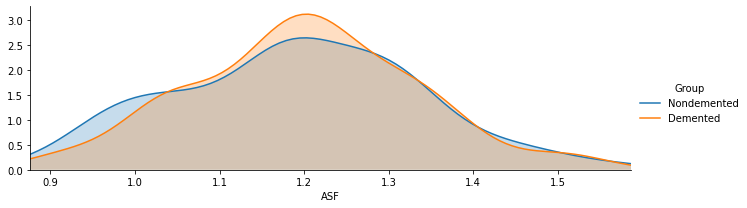

In [21]:
for i in list(df.select_dtypes('number')):
  fig = sns.FacetGrid(df,hue="Group", aspect=3)
  fig.map(sns.kdeplot,i,shade= True)
  fig.set(xlim=(df[i].min(), df[i].max()))
  fig.add_legend()
  plt.show()

## Feature Engineering

### Feature Transformation
#### One Hot Encoding for Categorical Features

In [22]:
## One Hot Encoding Categorical Feature
col_dummies = df.drop('Group',axis=1).select_dtypes(exclude='number').columns
df_dummies = pd.get_dummies(df,columns=col_dummies,dummy_na=False)
df_dummies.head()

,Group,MR Delay,Age,EDUC,SES,MMSE,CDR,nWBV,ASF,M/F_F,M/F_M
0,Nondemented,0,87,14,2.0,27.0,0.0,0.696,0.883,0,1
1,Nondemented,457,88,14,2.0,30.0,0.0,0.681,0.876,0,1
2,Demented,0,75,12,2.0,23.0,0.5,0.736,1.046,0,1
3,Demented,560,76,12,2.0,28.0,0.5,0.713,1.010,0,1
4,Demented,1895,80,12,2.0,22.0,0.5,0.701,1.034,0,1


### Scaling MinMax to 0-1

In [23]:
num_features = df.select_dtypes(include='number').columns
df_dummies[num_features] = MinMaxScaler().fit_transform(df_dummies[num_features])
df_dummies.head()

,Group,MR Delay,Age,EDUC,SES,MMSE,CDR,nWBV,ASF,M/F_F,M/F_M
0,Nondemented,0.000000,0.710526,0.470588,0.25,0.884615,0.00,0.269430,0.009845,0,1
1,Nondemented,0.173172,0.736842,0.470588,0.25,1.000000,0.00,0.191710,0.000000,0,1
2,Demented,0.000000,0.394737,0.352941,0.25,0.730769,0.25,0.476684,0.239100,0,1
3,Demented,0.212202,0.421053,0.352941,0.25,0.923077,0.25,0.357513,0.188467,0,1
4,Demented,0.718075,0.526316,0.352941,0.25,0.692308,0.25,0.295337,0.222222,0,1


# Modeling

## Data Train Test Split
We split Data Set into 80 % for Data Train and 20 % Data Test

In [0]:
X = df_dummies.drop(['Group'],axis=1)
y = df_dummies['Group'].replace(['Demented', 'Nondemented'], [1,0])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=2020)

# Using Scikit-Learn

### Cross Validation
- Finding  Baseline Model

In [0]:
from sklearn.metrics import f1_score,auc,confusion_matrix,accuracy_score,recall_score,precision_score, roc_auc_score, roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier

In [0]:
import itertools
# prepare models
# Intput
## X_train, X_test, y_train, y_test: Numpy array
## features: list variabel yang akan diikutkan dalam modelling
## list model: List dari model yang akan digunakan
## n_cv: integer banyaknya cross validasi
## seed: integer nilai seed
# Output: pandas dataframe
def cv_model(X_train, 
             y_train,
             X_test,
             y_test,
             list_model,
             features = 'All',
             n_cv = 5,
             seed = 2020,
             type_model = 'Base',
             n_comb = 1,
             meta_learner = None
             ):
    
    cv= StratifiedKFold(n_splits=n_cv,random_state=seed)
    
    if isinstance(features, str):
      if features == 'All':
        features = list(X_train)

    if type_model == 'Base':
      list_model_iter = list_model
    elif type_model == 'Voting':
      models_comb=list(itertools.combinations(list_model, n_comb))    
      list_comb = list(map(list,models_comb))
      list_model_iter =list_comb
    elif type_model == 'Stacking':
      models_comb=list(itertools.combinations(list_model, n_comb))    
      list_comb = list(map(list,models_comb))
      list_model_iter =list_comb
      
    def nama(string_):
        nama=''
        for a in range(n_comb):
            nama+=" + " + str(string_[a][0])
        return nama
    
    def get_model_k(list_m):
        result=[]
        for i in range(n_comb):
            result.append(list_m[i][1])
        return result  

    scoring = {
        'AUC': 'roc_auc',
        'Accuracy':'accuracy',
        'Precision':'precision',
        'Recall':'recall',
        'F1':'f1'
        }

    acc_train = [];acc_val =[];acc_test = [];
    prec_train = [];prec_val = [];prec_test = [];
    rec_train = [];rec_val = [];rec_test = [];
    AUC_train = [];AUC_val =[];AUC_test=[];       
    f1_train = [];f1_val = [];f1_test = [];   
    fit_time = []
    pred_time = []
    names = []

    for i in tqdm(range(len(list_model_iter))):

        if type_model == 'Base':
          model = list_model_iter[i][1]
          names.append(list_model_iter[i][0])
        elif type_model == 'Voting':
          model_clf = get_model_k(list_model_iter[i])
          model = EnsembleVoteClassifier(clfs=model_clf,voting='soft')
          names.append(nama(list_model_iter[i]))
        elif type_model == 'Stacking':
          model_clf = get_model_k(list_model_iter[i])
          model = StackingClassifier(
              classifiers=model_clf, 
              meta_classifier=meta_learner[1],
              use_probas=True,average_probas=False
              )
          names.append(nama(list_model_iter[i]))
        
        score = cross_validate(model, X_train[features], y_train,cv=cv, scoring=scoring, n_jobs=2,return_train_score=True)
        
        acc_train.append(score['train_Accuracy'].mean())
        prec_train.append(score['train_Precision'].mean())
        rec_train.append(score['train_Recall'].mean())
        AUC_train.append(score['train_AUC'].mean())
        f1_train.append(score['train_F1'].mean())

        acc_val.append(score['test_Accuracy'].mean())
        prec_val.append(score['test_Precision'].mean())
        rec_val.append(score['test_Recall'].mean())
        AUC_val.append(score['test_AUC'].mean())
        f1_val.append(score['test_F1'].mean())
        
        fit_time.append(score['fit_time'].mean())
        pred_time.append(score['score_time'].mean())
        
        test = model.fit(X_train[features],y_train).predict(X_test[features])
         
        acc_test.append(accuracy_score(test,y_test))
        prec_test.append(precision_score(test,y_test))
        rec_test.append(recall_score(test,y_test))
        AUC_test.append(roc_auc_score(test,y_test))
        f1_test.append(recall_score(test,y_test))
        
        print(
            '\nAlgoritma : ' + str(names[i])  +
            '\n' +
            '\nAccuracy : ' + 'val = ' + str(round(acc_val[i],2)) + '  |  test = '+ str(round(acc_test[i],2)) +
            '\nPrecision : ' + 'val = '+ str(round(prec_val[i],2)) + '  |  test = '+ str(round(prec_test[i],2)) +
            '\nRecall : ' + 'val = ' + str(round(acc_val[i],2))+ '  |  test = '+str(round(rec_test[i],2)) +
            '\nAUC : ' + 'val = ' + str(round(AUC_val[i],2)) +'  |  test = '+str(round(AUC_test[i],2)) +
            '\nF1 : ' + 'val = ' + str(round(f1_val[i],2)) +'  |  test = '+str(round(f1_test[i],2)) +
            '\n'
            )
    
    evaluate_model = pd.DataFrame({'Metode':names, 
                                   
                                   'Accuracy_train': acc_train,
                                   'Precision_train': prec_train,
                                   'Recall_train':rec_train,
                                   'F1_train':f1_train,
                                   'AUC_train':AUC_train,

                                   'Accuracy_val': acc_val,
                                   'Precision_val': prec_val,
                                   'Recall_val':rec_val,
                                   'F1_val':f1_val,
                                   'AUC_val':AUC_val,

                                   'Accuracy_test': acc_test,
                                   'Precision_test': prec_test,
                                   'Recall_test':rec_test,
                                   'F1_test':f1_test,
                                   'AUC_test':AUC_test,
                                   
                                   'Fit Time':fit_time, 
                                   'Pred Time':pred_time}).sort_values('AUC_test',ascending=False)

    if type_model == 'Stacking':
      print('Meta-Learner = '+ meta_learner[0]);
      evaluate_model['meta_learner'] = str(meta_learner[0])

    return evaluate_model

In [0]:
seed = 2020
models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('LogReg',LogisticRegression()))
models.append(('XGB', XGBClassifier(random_state = seed)))
models.append(('Gradient Boosting', GradientBoostingClassifier(random_state = seed)))
models.append(('ExtraTree', ExtraTreesClassifier()))
models.append(('LGBM', LGBMClassifier(eval_metric='AUC')))

In [28]:
train_1 = cv_model(X_train, 
             y_train,
             X_test,
             y_test,
             models,
             features = 'All',
             n_cv = 5,
             seed = 2020,
             type_model = 'Base',
             n_comb = 1,
             meta_learner = None
             )
train_1

 12%|█▎        | 1/8 [00:01<00:08,  1.23s/it]


Algoritma : CART

Accuracy : val = 0.9  |  test = 0.91
Precision : val = 0.88  |  test = 0.92
Recall : val = 0.9  |  test = 0.89
AUC : val = 0.9  |  test = 0.91
F1 : val = 0.9  |  test = 0.89


Algoritma : NB

Accuracy : val = 0.94  |  test = 0.96
Precision : val = 0.98  |  test = 0.92
Recall : val = 0.94  |  test = 1.0
AUC : val = 0.95  |  test = 0.96
F1 : val = 0.94  |  test = 1.0



 50%|█████     | 4/8 [00:02<00:02,  1.37it/s]


Algoritma : RF

Accuracy : val = 0.95  |  test = 0.96
Precision : val = 0.99  |  test = 0.92
Recall : val = 0.95  |  test = 1.0
AUC : val = 0.96  |  test = 0.96
F1 : val = 0.94  |  test = 1.0


Algoritma : LogReg

Accuracy : val = 0.93  |  test = 0.96
Precision : val = 0.97  |  test = 0.92
Recall : val = 0.93  |  test = 1.0
AUC : val = 0.95  |  test = 0.96
F1 : val = 0.92  |  test = 1.0



 62%|██████▎   | 5/8 [00:04<00:03,  1.33s/it]


Algoritma : XGB

Accuracy : val = 0.95  |  test = 0.97
Precision : val = 0.98  |  test = 0.94
Recall : val = 0.95  |  test = 1.0
AUC : val = 0.96  |  test = 0.98
F1 : val = 0.95  |  test = 1.0



 75%|███████▌  | 6/8 [00:05<00:02,  1.09s/it]


Algoritma : Gradient Boosting

Accuracy : val = 0.94  |  test = 0.95
Precision : val = 0.97  |  test = 0.89
Recall : val = 0.94  |  test = 1.0
AUC : val = 0.95  |  test = 0.95
F1 : val = 0.94  |  test = 1.0



 88%|████████▊ | 7/8 [00:06<00:00,  1.02it/s]


Algoritma : ExtraTree

Accuracy : val = 0.95  |  test = 0.95
Precision : val = 0.97  |  test = 0.92
Recall : val = 0.95  |  test = 0.97
AUC : val = 0.98  |  test = 0.95
F1 : val = 0.94  |  test = 0.97



100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Algoritma : LGBM

Accuracy : val = 0.94  |  test = 0.96
Precision : val = 0.96  |  test = 0.94
Recall : val = 0.94  |  test = 0.97
AUC : val = 0.97  |  test = 0.96
F1 : val = 0.94  |  test = 0.97



,Metode,Accuracy_train,Precision_train,Recall_train,F1_train,AUC_train,Accuracy_val,Precision_val,Recall_val,F1_val,AUC_val,Accuracy_test,Precision_test,Recall_test,F1_test,AUC_test,Fit Time,Pred Time
4,XGB,0.981544,0.998291,0.964247,0.980890,0.999535,0.949661,0.978998,0.917931,0.946685,0.961946,0.973333,0.944444,1.000000,1.000000,0.975610,0.528384,0.008142
1,NB,0.942112,0.976254,0.904737,0.939058,0.953703,0.942938,0.978734,0.904368,0.939168,0.949248,0.960000,0.916667,1.000000,1.000000,0.964286,0.002988,0.007991
2,RF,1.000000,1.000000,1.000000,1.000000,1.000000,0.946215,0.985165,0.904138,0.942301,0.962686,0.960000,0.916667,1.000000,1.000000,0.964286,0.180906,0.028235
3,LogReg,0.938750,0.984919,0.889425,0.934699,0.961516,0.929492,0.970085,0.883908,0.924641,0.953550,0.960000,0.916667,1.000000,1.000000,0.964286,0.015929,0.006595
7,LGBM,1.000000,1.000000,1.000000,1.000000,1.000000,0.942938,0.964428,0.917931,0.940060,0.965927,0.960000,0.944444,0.971429,0.971429,0.960714,0.034397,0.013726
5,Gradient Boosting,0.999160,1.000000,0.998291,0.999142,1.000000,0.939605,0.965856,0.911034,0.936582,0.948832,0.946667,0.888889,1.000000,1.000000,0.953488,0.117205,0.008807
6,ExtraTree,1.000000,1.000000,1.000000,1.000000,1.000000,0.946215,0.971591,0.917931,0.943448,0.977712,0.946667,0.916667,0.970588,0.970588,0.948709,0.138340,0.029309
0,CART,1.000000,1.000000,1.000000,1.000000,1.000000,0.895932,0.883055,0.911034,0.896353,0.895947,0.906667,0.916667,0.891892,0.891892,0.906472,0.003423,0.007077


Based on the leaderboard of K-fold Cross Validation using k =5 , Model with XGBoost Algorithm has the best metrics performance AUC, with score AUC 0.961946


#### Feature Selection Based on XGB's Features Importance

In [29]:
XGB = XGBClassifier(random_state= seed)
XGB = XGB.fit(X_train, y_train)
importances=XGB.feature_importances_

indices = np.argsort(importances)[::-1]
selected_XGB = pd.DataFrame({'Variables' : X_train.columns[indices], "Importance":importances[np.argsort(importances)[::-1]]})
selected_XGB

,Variables,Importance
0,CDR,0.778692
1,M/F_F,0.034894
2,MMSE,0.034052
3,SES,0.030666
4,Age,0.028315
5,ASF,0.027676
6,MR Delay,0.026623
7,nWBV,0.025933
8,EDUC,0.013149
9,M/F_M,0.000000


In [0]:
selected_Feature_XGB = ['CDR','M/F_F','MMSE','SES','Age','ASF','MR Delay','nWBV','EDUC']

### Hyperparameter Tuning

In [31]:
param_grid_XGB={'n_estimators':[100,300,500], 
            'learning_rate': [0.1,0.05,0.01], 
            'max_depth':[4,6,10], 
            'min_samples_leaf':[3,5,10] ,
            'max_features':[1.0,0.3,0.1] 
           }
xgb=XGBClassifier()
grid_cv_XGB = GridSearchCV(xgb, param_grid_XGB, cv=5)
grid_cv_XGB.fit(X_train[selected_Feature_XGB],y_train)
grid_cv_XGB.best_params_        

{'learning_rate': 0.1,
 'max_depth': 6,
 'max_features': 1.0,
 'min_samples_leaf': 3,
 'n_estimators': 100}

### Final Model Using Scikit-Learn

In [0]:
def evaluate_model_testing(model, X_test, y_test):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    print(classification_report(y_test, y_pred))
    print("Accuracy on testing :" + str(accuracy_score(y_test, y_pred)))
    print("AUC of Precision-Recall Curve on Testing :" + str(auc(recall, precision)))
    (tn, fp, fn, tp ) = confusion_matrix(y_test, y_pred).ravel()
    print("TN :" + str(tn), "\t""FP :" + str(fp), "\t""FN :" + str(fn), "\t""TP :" + str(tp))
    print("{} "+str((fp+tp)/(fp+tp+tn+fn)))
    print("EDR "+str((fp)/(fp+tp)))
    df = pd.DataFrame({'y_Actual':y_test,'y_Predicted':y_pred})
    confusion_matrix_ = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)
    sns.heatmap(confusion_matrix_, annot=True)
    plt.show()
    

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        39
           1       1.00      0.92      0.96        36

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75

Accuracy on testing :0.96
AUC of Precision-Recall Curve on Testing :0.9859065130489103
TN :39 	FP :0 	FN :3 	TP :33
{} 0.44
EDR 0.0


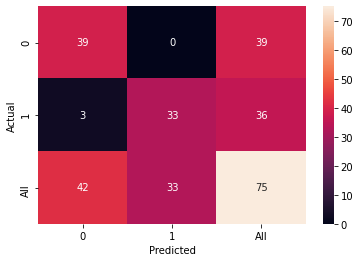

In [33]:
model_XGB = XGBClassifier(
 learning_rate= 0.1,
 max_depth= 6,
 max_features= 1.0,
 min_samples_leaf= 3,
 n_estimators = 100
).fit(X_train[selected_Feature_XGB],y_train)

evaluate_model_testing(model_XGB,X_test[selected_Feature_XGB],y_test)

From the output , the model with hyperparamer tuned and feature selection has increased the AUC to 0.9859

# Using TensorFlow
source reference : 
https://blog.tensorflow.org/2019/03/how-to-train-boosted-trees-models-in-tensorflow.html


In [0]:
features = selected_Feature_XGB
X_train = X_train[features]
X_test = X_test[features]
fc = tf.feature_column
feature_columns = []
for feature_name in features:
  feature_columns.append(tf.feature_column.numeric_column(feature_name,
                                                          dtype=tf.float32))

In [0]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = dataset.repeat(n_epochs)
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(X_train, y_train)
eval_input_fn = make_input_fn(X_test, y_test, shuffle=False, n_epochs=1)

In [0]:
tf.keras.backend.set_floatx('float32')
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
result = linear_est.evaluate(eval_input_fn)

In [41]:
result

{'accuracy': 0.96,
 'accuracy_baseline': 0.52,
 'auc': 0.97613966,
 'auc_precision_recall': 0.98089886,
 'average_loss': 0.17375536,
 'global_step': 100,
 'label/mean': 0.48,
 'loss': 0.17375536,
 'precision': 1.0,
 'prediction/mean': 0.44961384,
 'recall': 0.9166667}

In [0]:
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches,center_bias=True)
est.train(train_input_fn, max_steps=100)
result = est.evaluate(eval_input_fn)

In [40]:
result

{'accuracy': 0.96,
 'accuracy_baseline': 0.52,
 'auc': 0.97613966,
 'auc_precision_recall': 0.98089886,
 'average_loss': 0.17375536,
 'global_step': 100,
 'label/mean': 0.48,
 'loss': 0.17375536,
 'precision': 1.0,
 'prediction/mean': 0.44961384,
 'recall': 0.9166667}

In [0]:
# Make predictions.
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])
# Plot results.
ID = 1
example = df_dfc.iloc[ID]  # Choose ith example from evaluation set.
TOP_N = 8  # View top 8 features.
sorted_ix = example.abs().sort_values()[-TOP_N:].index
ax = example[sorted_ix].plot(kind='barh')

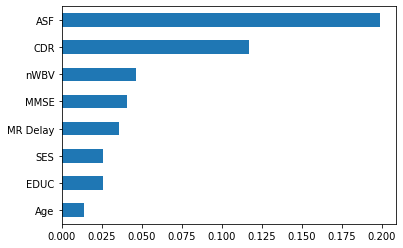

In [45]:
ax = example[sorted_ix].plot(kind='barh')

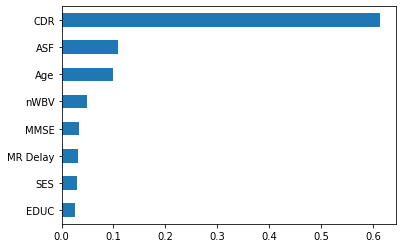

In [39]:
# Get importances
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Visualize importances.
N = 8
ax = (df_imp.iloc[0:N][::-1].plot(kind='barh'))